In [1]:
import noise

from pdesign import canvas, shapes, lines
from pdesign import transforms as trans
from pdesign import smooth as smooth_lib


import numpy as np
from shapely.geometry import MultiLineString, LineString, Point, Polygon, MultiPoint
from shapely.geometry import box as Box
from shapely.ops import unary_union
from shapely import affinity
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from skimage.draw import line, circle_perimeter
from skimage import draw

from ipywidgets import widgets
from ipywidgets import interact, interact_manual, interactive

from matplotlib.collections import LineCollection
from matplotlib.collections import PatchCollection

from scipy.ndimage import filters
from scipy import signal
from scipy.stats import multivariate_normal

import skimage
from skimage.feature import shape_index

from skimage import draw
from sklearn import preprocessing
from scipy import interpolate

from plottermagic.io import io

from scipy.ndimage import filters
from scipy import ndimage, misc

from skimage import exposure

from skimage.transform import rescale

from skimage import io as skio


from skimage.morphology import disk
from skimage.filters import rank, unsharp_mask

from skimage.transform import pyramids
from skimage import transform

import heapq

from tqdm import notebook

In [206]:
img = io.load_image("/Users/gnb/source_photos/marie/midport_nobackround.jpg", as_type='grey').astype(float)
img = transform.rescale(img, 1/10)



#base_img = io.load_image("/Users/gnb/source_photos/geoff_japan.jpg", as_type='grey').astype(float)

img.shape

(576, 384)

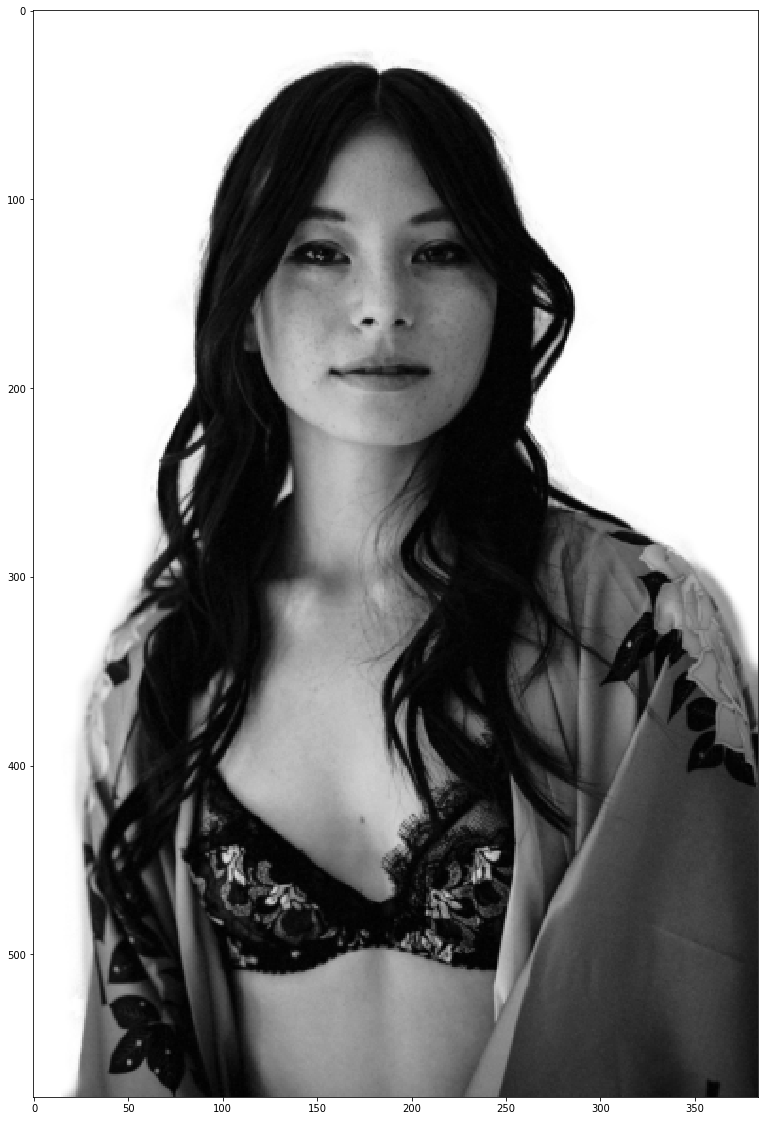

In [207]:
plt.figure(figsize=(20,20))
plt.imshow(-img, cmap='Greys')

In [262]:
img_original = img.copy()
intensity = img.copy()
has_seen = img.copy()<0



dithered = np.zeros_like(img)

threshold = 60
#diffuse_radius = 50

diffuse_radius = 0.03*img.shape[0]

k = 2

g_minus = 5
g_plus = 1

print(diffuse_radius)

17.28


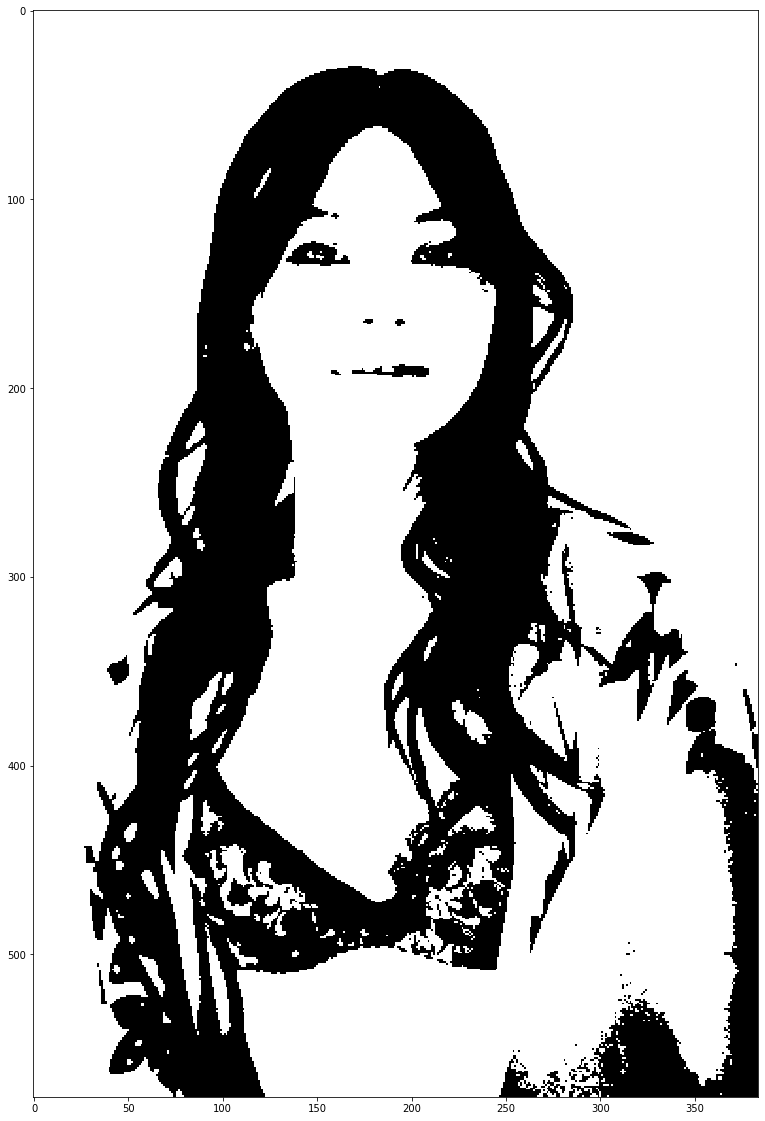

In [263]:
plt.figure(figsize=(20,20))
plt.imshow(img<threshold, cmap='Greys')

In [264]:
xx, yy = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]), indexing='ij')

In [265]:
hp = []
ptuples = np.dstack([np.maximum(img, 255-img), xx, yy]).reshape(-1, 3)

for i, x, y in ptuples:
    heapq.heappush(hp, (i, (int(x),int(y))))


In [266]:
#r_min, r_max = 0.01, 0.25
r_min, r_max = 0.75, 1.25
stipple_size = lambda i :r_min + ((r_max-r_min)/255)*(255-i)

In [267]:
def error_diffuse(pind, err, intensity, r):
    
    """
    cx, cy = draw.circle(*pind, diffuse_radius, shape=intensity.shape)
    cx, cy = cx[np.argwhere(~has_seen[cx, cy])].reshape(-1), cy[np.argwhere(~has_seen[cx, cy])].reshape(-1)
    
    rmn = ((cx-pind[0])**2+(cy-pind[1])**2)**0.5
    
    wmn = intensity[cx, cy]
    if err<0:
        wmn = 255 - intensity[cx, cy]

    wmn /= rmn**diffuse_pow
    wmn = wmn/np.sum(wmn)
    
    if err<0:
        s = (1/r)**g_minus
    else:
        s = r**g_plus
        
    e0 = (np.pi*r**2 - 1)*k
    
    intensity[cx, cy] += (err+e0)*s*wmn
    intensity = np.clip(intensity, 0, 255)
    
    """
    
    cx, cy = draw.circle(*pind, diffuse_radius, shape=intensity.shape)
    cx, cy = cx[np.argwhere(~has_seen[cx, cy])].reshape(-1), cy[np.argwhere(~has_seen[cx, cy])].reshape(-1)
    
    if len(cx)>0:
    
        rmn = ((cx-pind[0])**2+(cy-pind[1])**2)**0.5

        wmn = intensity[cx, cy]
        if err<0:
            wmn = 255-wmn

        wmn = wmn/(rmn**k)
        wmn = wmn/np.maximum(np.sum(wmn), 1e-5)
        
        if err>0:
            s = r**g_plus
        else:
            s = r**-g_minus

        intensity[cx, cy] += err*wmn*s
        intensity[cx, cy] = np.clip(intensity[cx, cy], 0, 255)
        
        
        
    

In [268]:
dumb_count = 0 
stipples = []

while len(hp)>0:
    
    dumb_count+=1
    
    if dumb_count%(img.shape[0]*img.shape[1]//10)==0:
        print(dumb_count, np.mean(has_seen))
    
        
    
        
    priority, pind = heapq.heappop(hp)
    
    new_priority = np.maximum(intensity[pind], 255-intensity[pind])
    if new_priority != priority:
        heapq.heappush(hp, (new_priority, pind))
    else:
        
        r = stipple_size(intensity[pind])

        if intensity[pind]<threshold:
            app = 0
            stipples.append((pind, r))
        else:
            app = 255

        dithered[pind] = app
        has_seen[pind] = True

        err = intensity[pind]-app

        error_diffuse(pind, err, intensity, r)
    
    
    """
    if dumb_count>300000:
        break
    """
    
    

22118 0.015055338541666666
44236 0.028397171585648147
66354 0.04133662471064815
88472 0.052915219907407406
110590 0.0636890552662037
132708 0.07463017216435185
154826 0.0859691478587963
176944 0.09593370225694445
199062 0.10453287760416667
221180 0.11200177228009259
243298 0.11927173755787036
265416 0.12543854890046297
287534 0.1308910228587963
309652 0.1359546802662037
331770 0.1408058449074074
353888 0.14574743200231483
376006 0.15296314380787038
398124 0.17194733796296297
420242 0.1971164279513889
442360 0.22789171006944445
464478 0.26158763744212965
486596 0.29588035300925924
508714 0.33195439091435186
530832 0.3679606119791667
552950 0.4049479166666667
575068 0.44493724681712965
597186 0.4851888020833333
619304 0.5256980613425926
641422 0.5657913773148148
663540 0.6035111038773148
685658 0.6345576533564815
707776 0.7345558449074074
729894 0.8345540364583334
752012 0.9345522280092593


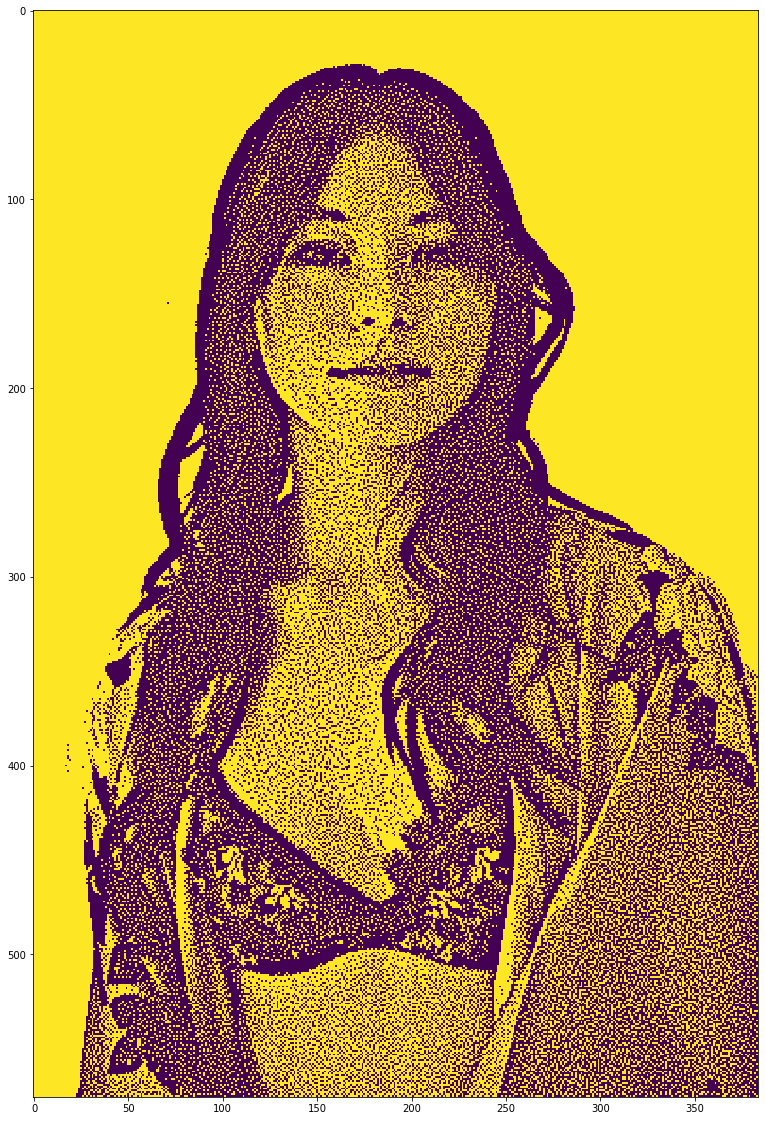

In [269]:
fig,ax = plt.subplots(figsize=(20,20))
ax.imshow(dithered)

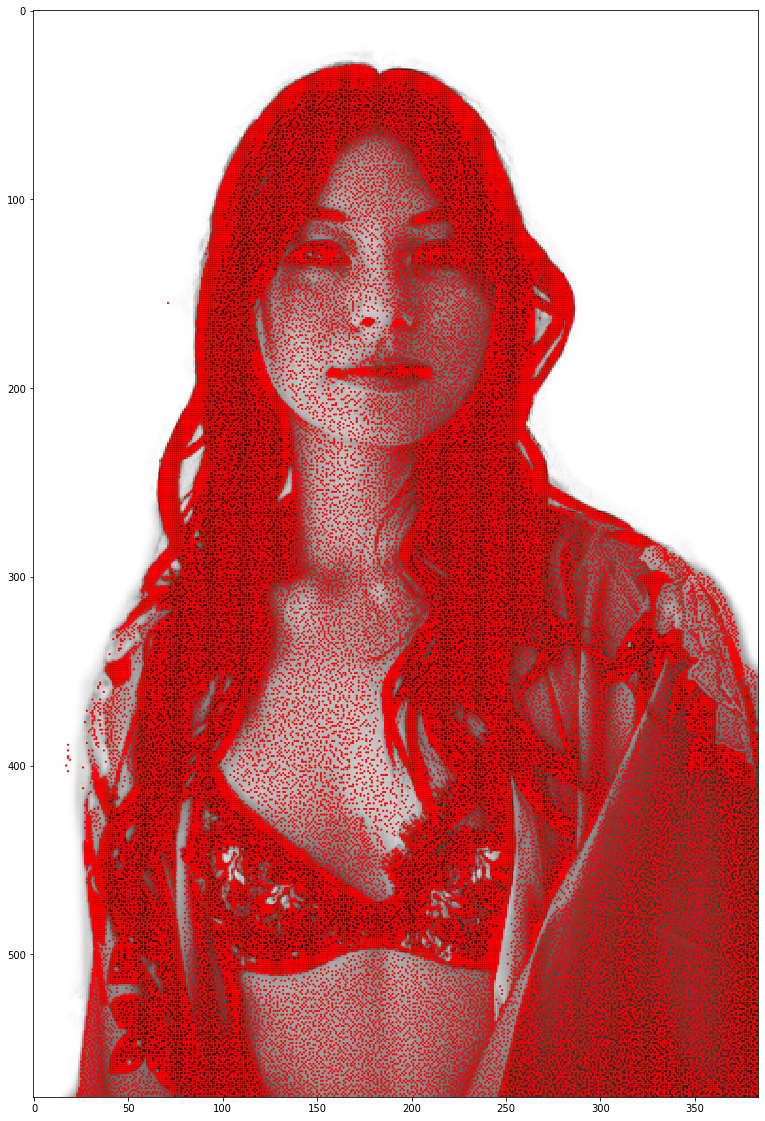

In [270]:
fig,ax = plt.subplots(figsize=(20,20))
ax.imshow(-img_original, cmap='Greys')
ax.add_collection(PatchCollection([Circle(xy[::-1], r/4) for xy, r in stipples], color='red', alpha=1))

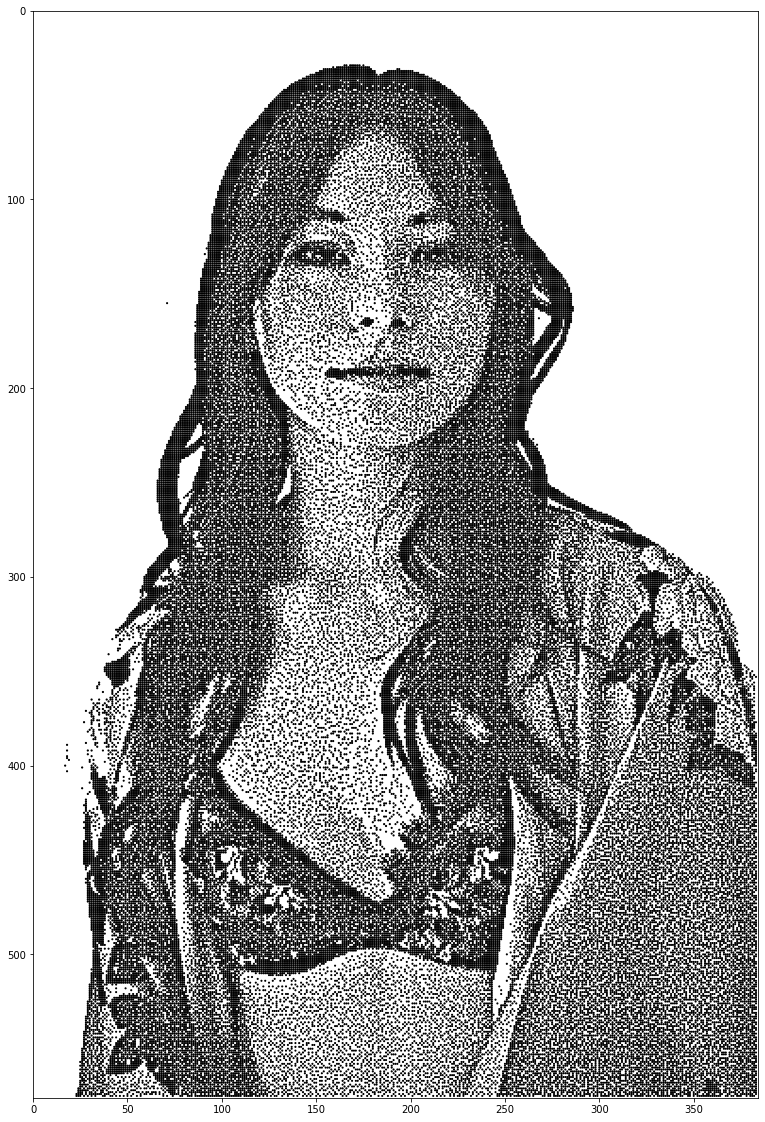

In [271]:
fig,ax = plt.subplots(figsize=(20,20))
ax.set_xlim(0, img_original.shape[1])
ax.set_ylim(img_original.shape[0], 0)
ax.add_collection(PatchCollection([Circle(xy[::-1], radius=r/4) for xy, r in stipples], color='black', alpha=1))
ax.set_aspect('equal')

In [272]:
rescale = img.shape[1]/9
#stips = [affinity.translate(affinity.scale(Point(xy[::-1]).buffer(0.25*0.0393701*72/2*(1+(r-r_min)/(r_max - r_min))), 1/rescale, 1/rescale, origin=(0,0)), 1,0) for xy, r in stipples]

stips = [Point(11 - (xy[1]/rescale + 1), xy[0]/rescale).buffer(0.25*0.0393701/2) for xy,r in stipples]

In [273]:
picture = canvas.Canvas(paper_size=(11,14), margin_percent=0.05, origin='corner')
picture_bbox = Box(picture.bbox[0,0], picture.bbox[0,1], picture.bbox[1,0], picture.bbox[1,1])
dp = {
    "alpha":0.7,
    "linewidth":0.25*0.0393701*72,
    "clear":False,
}

<Figure size 792x1008 with 0 Axes>

In [274]:
0.25*0.0393701*72/2*(1+(r-r_min)/(r_max - r_min))

0.7086618

In [275]:
"""
picture.make_canvas()
picture.add_grid(11,14)
picture.plot_shapes(stips, **dp)
picture.fig
"""


'\npicture.make_canvas()\npicture.add_grid(11,14)\npicture.plot_shapes(stips, **dp)\npicture.fig\n'

In [276]:
mpl_circles = [Circle((11 - (xy[1]/rescale + 1), xy[0]/rescale), 0.25*0.0393701/2) for xy,r in stipples]

None


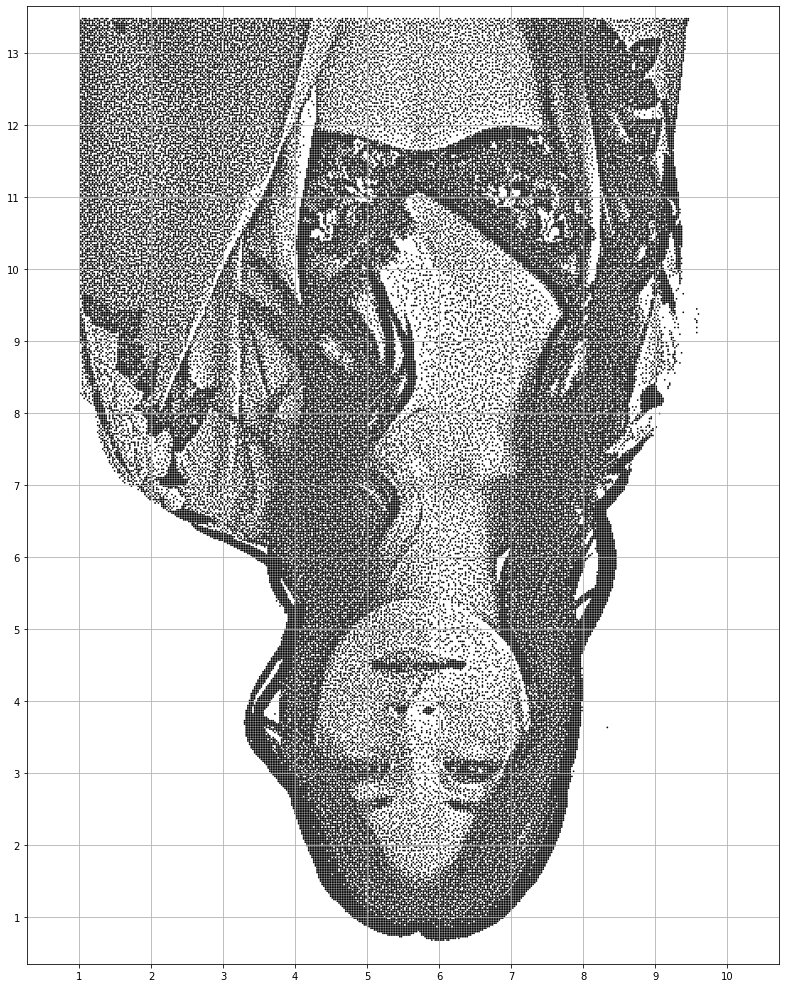

In [277]:
picture.make_canvas()
picture.add_grid(11,14)
picture.ax.add_collection(PatchCollection(mpl_circles, color='black', alpha = 2))
picture.fig